In [226]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns


In [227]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer


In [228]:
os.getcwd()

'C:\\Users\\jonah\\Documents\\DataScienceBlogpostProject\\data'

In [229]:
path="C:\\Users\\jonah\\Documents\\DataScienceBlogpostProject\\data"
os.chdir(path)

In [230]:
os.getcwd()

'C:\\Users\\jonah\\Documents\\DataScienceBlogpostProject\\data'

# Question 1: Which months are the busiest?

I'm first interested in what the data trend looks like over time. Are there more listings every month as new hosts enter the market? Does it vary strongly by season?

In [231]:
cal_df = pd.read_csv("calendar.csv")
list_df = pd.read_csv("listings.csv")

`cal_df` is a dataframe of all listings, whether they're available for each day of the year, and their price if so.

Are they marked by whether they're booked? Doesn't look like it; `available` is just if they can be booked at all. 

In [232]:
# turning `available` into a boolean:
cal_df_tf = cal_df
cal_df = cal_df.replace("t", True)
cal_df = cal_df.replace("f", False)
# turning price to float
cal_df["price"] = cal_df["price"].replace({'\$': '', '\,': ''}, regex=True)
cal_df["price"] = pd.to_numeric(cal_df["price"])
cal_df["date"] = pd.to_datetime(cal_df["date"])

cal_df

,listing_id,date,available,price
0,241032,2016-01-04,True,85.0
1,241032,2016-01-05,True,85.0
2,241032,2016-01-06,False,NaN
3,241032,2016-01-07,False,NaN
4,241032,2016-01-08,False,NaN
...,...,...,...,...
1393565,10208623,2016-12-29,False,NaN
1393566,10208623,2016-12-30,False,NaN
1393567,10208623,2016-12-31,False,NaN
1393568,10208623,2017-01-01,False,NaN


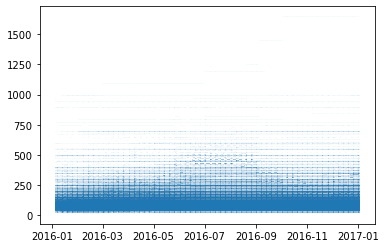

In [233]:
# first trying a scatter plot
plt.scatter(cal_df["date"], cal_df["price"], s=0.0001)


Well, that's not very informative!

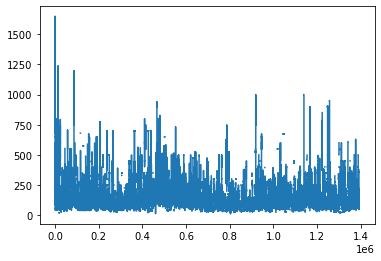

In [234]:
# or maybe a line plot?
plt.plot(cal_df["price"])

Neither is that! What's going on here?

In [235]:
print(cal_df["price"].min())
print(cal_df["price"].max())

10.0
1650.0


Looks like we've got a very price wide range. I doubt the values are distributed evenly over [10, 1650]. I'm going to split the dataframe up into those equal to or less than $500, and those above. $500 is hardly cheap, but sounds reasonable as an upper bound to the normal range.

In [236]:
expensive_df = cal_df[cal_df["price"] > 500]
cheap_df = cal_df[cal_df["price"] <= 500]
print(len(expensive_df))
print(len(cheap_df))

11959
922583


In a histogram of all prices, it's very hard to make out any meaningful pattern because of the long right tail - a very small number of extremely high prices. 

As we can see above, there are 922583 entries for prices at $500 or below - still hardly cheap for many of these! Compare that to the mere 11959 samples over $500. However, with the maximum price of $1650, this spreads the price range out so wide the histogram becomes useless.

Text(0.5, 1.0, 'Fig 3: Histogram of Seattle AirBnb Prices [limit: >$500]')

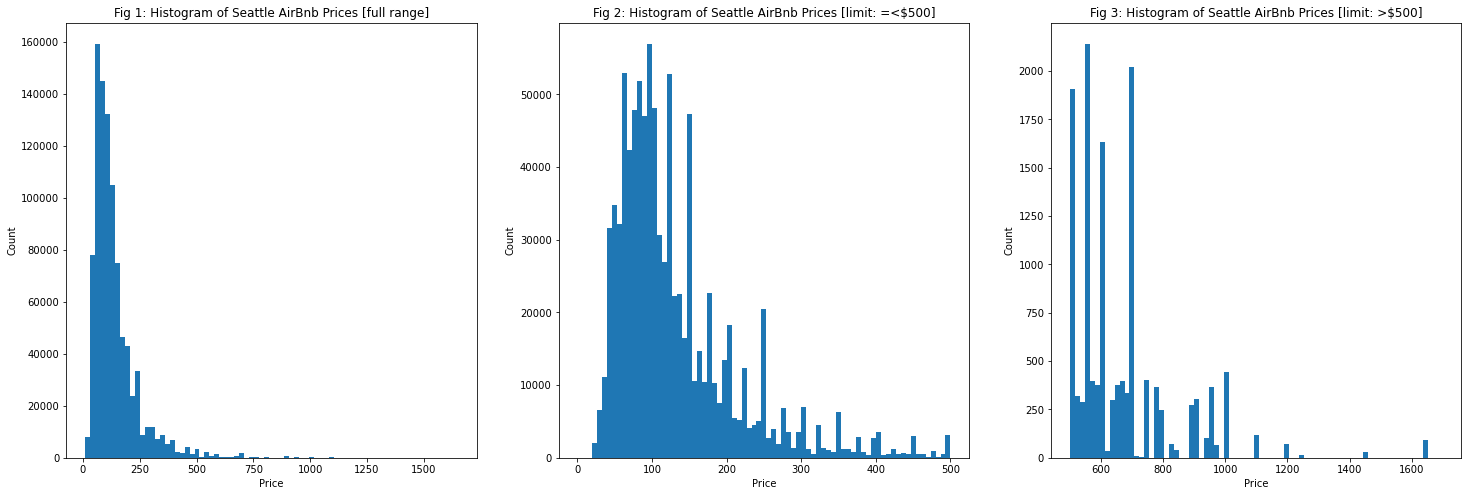

In [237]:
fig, ax = plt.subplots(1, 3, figsize = (25,8))

ax[0].hist(cal_df["price"], bins = 75)
ax[0].set_xlabel("Price")
ax[0].set_ylabel("Count")
ax[0].set_title("Fig 1: Histogram of Seattle AirBnb Prices [full range]")

ax[1].hist(cal_df["price"], bins = 75, range = [0, 500])
ax[1].set_xlabel("Price")
ax[1].set_ylabel("Count")
ax[1].set_title("Fig 2: Histogram of Seattle AirBnb Prices [limit: =<$500]")

ax[2].hist(cal_df["price"], bins = 75, range = [500, 1700])
ax[2].set_xlabel("Price")
ax[2].set_ylabel("Count")
ax[2].set_title("Fig 3: Histogram of Seattle AirBnb Prices [limit: >$500]")

In [238]:
print(cal_df["price"].mean())
print(cal_df["price"].std())

137.94485855103355
105.06287002526753


This is borne out in Fig 1, where even 75 bins still leaves it very hard to make out any pattern in the important core of prices below $250. 

Fig 2 is better. We see evidence of clumping, likely at increments of $5. The peak of the distribution is around $100, with a longer right tail, and no prices below $10.

Fig 3 should be read carefully - its y-axis values peak slightly above 2000, rather than suggesting a return to the same heights as Fig 2 shows at the peak of the density range. 

What we can conclude from these values is that the distribution is roughly normal with a mean of $138 and standard deviation of 105. Howver, it's bounded above 0, with a long right tail, and clear bunching at certain nominal values, likely multiples of 5. 

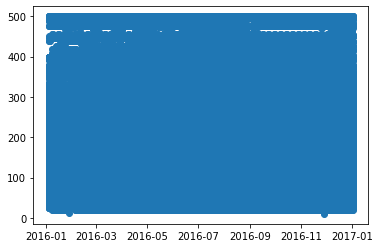

In [239]:
# revisiting scatter plot with `cheap_df`

plt.scatter(x = cheap_df["date"], y=cheap_df["price"])

Text(0.5, 1.0, 'Fig 5: Scatter Plot of Seattle AirBnb Prices [limit: =<$500]')

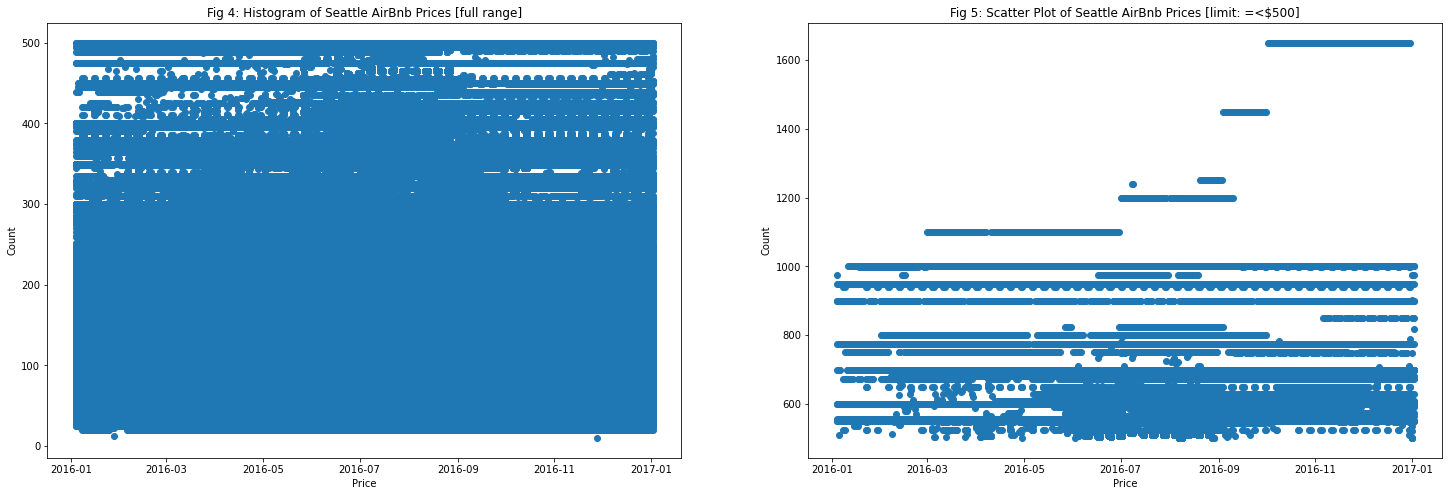

In [240]:
fig, ax = plt.subplots(1, 2, figsize = (25,8))

ax[0].scatter(x = cheap_df["date"], y=cheap_df["price"])
ax[0].set_xlabel("Price")
ax[0].set_ylabel("Count")
ax[0].set_title("Fig 4: Histogram of Seattle AirBnb Prices [full range]")

ax[1].scatter(x = expensive_df["date"], y = expensive_df["price"])
ax[1].set_xlabel("Price")
ax[1].set_ylabel("Count")
ax[1].set_title("Fig 5: Scatter Plot of Seattle AirBnb Prices [limit: =<$500]")


These are incomprehensible; simply too dense to make sense of. I'm going to try a simply bar plot by month.

In [241]:
cal_df["month"] = cal_df["date"].dt.month
cal_df["year"] = cal_df["date"].dt.year
count_df = cal_df.groupby(["year", "month"]).count()

Text(0.5, 1.0, 'Count of Listing IDs by Month and Year')

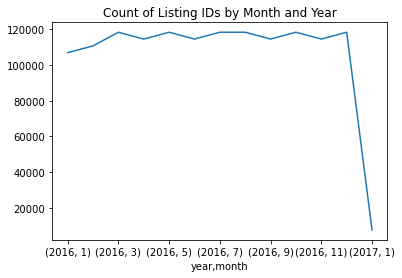

In [242]:
count_df["listing_id"].plot()
plt.title("Count of Listing IDs by Month and Year")

In [243]:
count_df

listing_id    date  available  price
year month                                      
2016 1          106904  106904     106904  59239
     2          110722  110722     110722  73321
     3          118358  118358     118358  83938
     4          114540  114540     114540  76037
     5          118358  118358     118358  79971
     6          114540  114540     114540  77244
     7          118358  118358     118358  74222
     8          118358  118358     118358  76347
     9          114540  114540     114540  77246
     10         118358  118358     118358  82438
     11         114540  114540     114540  81780
     12         118358  118358     118358  87061
2017 1            7636    7636       7636   5698

In [244]:
count_df_noindex = count_df.reset_index()
count_df_noindex

,year,month,listing_id,date,available,price
0,2016,1,106904,106904,106904,59239
1,2016,2,110722,110722,110722,73321
2,2016,3,118358,118358,118358,83938
3,2016,4,114540,114540,114540,76037
4,2016,5,118358,118358,118358,79971
5,2016,6,114540,114540,114540,77244
6,2016,7,118358,118358,118358,74222
7,2016,8,118358,118358,118358,76347
8,2016,9,114540,114540,114540,77246
9,2016,10,118358,118358,118358,82438


In [245]:
len(count_df_noindex["listing_id"])

13

Text(0.5, 1.0, 'Listings by month: By Listed Price')

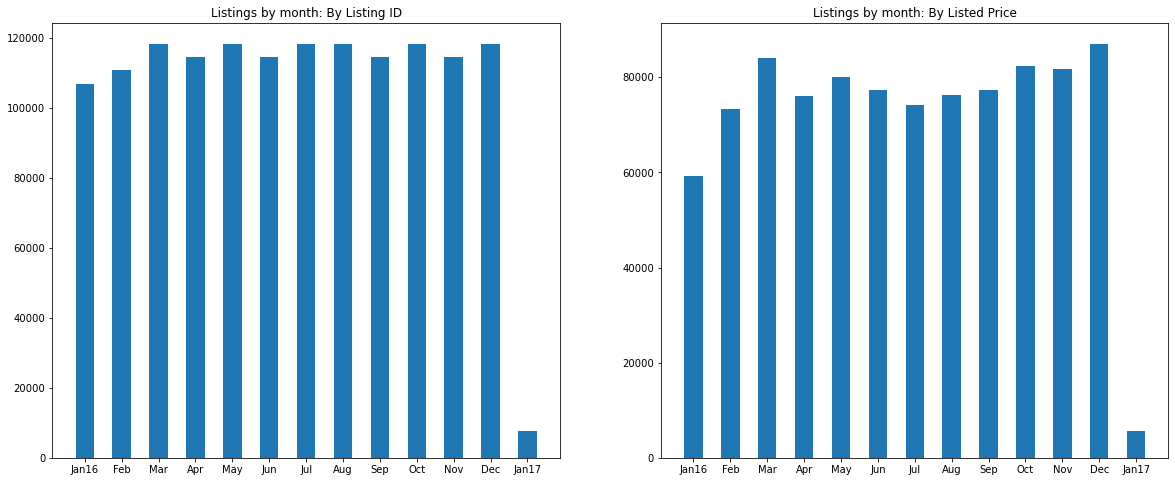

In [246]:
fig, ax = plt.subplots(1, 2, figsize = (20,8))

months = ["Jan16", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan17"]
ax[0].bar(x = months, height = count_df_noindex["listing_id"], width=0.5)
ax[0].set_title("Listings by month: By Listing ID")

ax[1].bar(x = months, height = count_df_noindex["price"], width=0.5)
ax[1].set_title("Listings by month: By Listed Price")

So, there's not a clear upward trend in listings. It looks like there's a collapse in January 2017 - most likely they don't have the whole month covered.

Listing by price is more variable - prices are only shown when the listings are available. Interestingly, it doesn't vary much by season - once you get into Spring, the number of available listings varies only a little bit month by month. The plunge in January 2017 is still clearly visible. 

Could the January 2017 collapse be simply due to the month not being fully covered?

In [247]:
cal_df["date"].max()

Timestamp('2017-01-02 00:00:00')

Yep! We've only got one day of the new year. No wonder it's so low!

# Question 2: Is the price level changing over time?

This is referring to the overall price level. In question 3, I'm going to see if individual listings see their prices change noticeably over time. 

In [248]:
cal_df

,listing_id,date,available,price,month,year
0,241032,2016-01-04,True,85.0,1,2016
1,241032,2016-01-05,True,85.0,1,2016
2,241032,2016-01-06,False,NaN,1,2016
3,241032,2016-01-07,False,NaN,1,2016
4,241032,2016-01-08,False,NaN,1,2016
...,...,...,...,...,...,...
1393565,10208623,2016-12-29,False,NaN,12,2016
1393566,10208623,2016-12-30,False,NaN,12,2016
1393567,10208623,2016-12-31,False,NaN,12,2016
1393568,10208623,2017-01-01,False,NaN,1,2017


In [249]:
cal_df_unavailable = cal_df[cal_df["available"] == False]
cal_df_available = cal_df[cal_df["available"] == True]

In [250]:
cal_df_available

,listing_id,date,available,price,month,year
0,241032,2016-01-04,True,85.0,1,2016
1,241032,2016-01-05,True,85.0,1,2016
9,241032,2016-01-13,True,85.0,1,2016
10,241032,2016-01-14,True,85.0,1,2016
14,241032,2016-01-18,True,85.0,1,2016
...,...,...,...,...,...,...
1393207,10208623,2016-01-06,True,87.0,1,2016
1393208,10208623,2016-01-07,True,87.0,1,2016
1393211,10208623,2016-01-10,True,87.0,1,2016
1393212,10208623,2016-01-11,True,87.0,1,2016


In [251]:
avail_df_gb = cal_df_available.groupby("month").mean()

In [252]:
avail_df_gb

,listing_id,available,price,year
month,,,,
1,5.409000e+06,1.0,122.912176,2016.087747
2,5.416562e+06,1.0,124.293927,2016.000000
3,5.383965e+06,1.0,128.644488,2016.000000
4,5.244016e+06,1.0,135.097005,2016.000000
5,5.234380e+06,1.0,139.538183,2016.000000
6,5.170853e+06,1.0,147.473137,2016.000000
7,5.200952e+06,1.0,152.094150,2016.000000
8,5.240480e+06,1.0,150.656594,2016.000000
9,5.279361e+06,1.0,143.255949,2016.000000


Text(0.5, 1.0, 'Listings by month: By Listing ID')

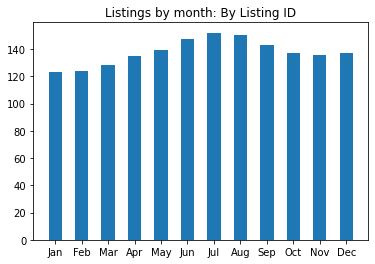

In [253]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.bar(x = months, height = avail_df_gb["price"], width=0.5)
plt.title("Listings by month: By Listing ID")

There seemy to be an overall increase from January to December, but the interesting change is in the seasons. Prices peak in June, July, and August. By Autumn they've fallen slightly, but still to a higher level than the spring. 

I'm going to run a very simple linear model to find the slope - what rate do we expect these prices to rise yearly?

In [254]:
avail_df_gb

,listing_id,available,price,year
month,,,,
1,5.409000e+06,1.0,122.912176,2016.087747
2,5.416562e+06,1.0,124.293927,2016.000000
3,5.383965e+06,1.0,128.644488,2016.000000
4,5.244016e+06,1.0,135.097005,2016.000000
5,5.234380e+06,1.0,139.538183,2016.000000
6,5.170853e+06,1.0,147.473137,2016.000000
7,5.200952e+06,1.0,152.094150,2016.000000
8,5.240480e+06,1.0,150.656594,2016.000000
9,5.279361e+06,1.0,143.255949,2016.000000


In [255]:
import statsmodels.api as sm


Text(0, 0.5, 'Average Price')

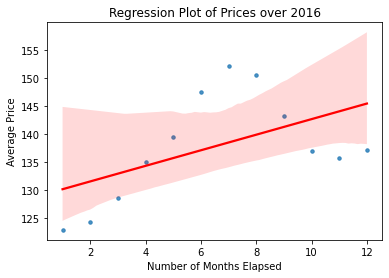

In [270]:
month_range = np.arange(1, 13, 1)
#len(month_range)

plt.title("Regression Plot of Prices over 2016")
sns.regplot(x = month_range, y = avail_df_gb["price"], line_kws={"color": "red"}, scatter_kws={"s": 12})
plt.xlabel("Number of Months Elapsed")
plt.ylabel("Average Price")

In [257]:
type(avail_df_gb["price"])
type(month_range)

numpy.ndarray

In [258]:
linear_reg_df = {"price": avail_df_gb["price"], "intercept": 1, "month": month_range}
linear_reg_df = pd.DataFrame(data=linear_reg_df)
linear_reg_df_exog = linear_reg_df.drop("price", axis=1)

In [259]:
linear_reg_df_exog

,intercept,month
month,,
1,1,1
2,1,2
3,1,3
4,1,4
5,1,5
6,1,6
7,1,7
8,1,8
9,1,9


# 1. Basic Month-level linear regression

In [260]:
# Month Model
month_model = sm.OLS(linear_reg_df["price"], linear_reg_df_exog)
month_model_result = month_model.fit()
print(month_model_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     3.842
Date:                Mon, 17 Oct 2022   Prob (F-statistic):             0.0784
Time:                        10:15:41   Log-Likelihood:                -41.592
No. Observations:                  12   AIC:                             87.18
Df Residuals:                      10   BIC:                             88.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    128.7879      5.222     24.663      0.0

c:\Users\jonah\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


This is a very simple regression - it accounts for the average level with the `intercept` variable, then takes the slope of a best-fit line over the `month` variable. 

It suggests an average increase in price of $1.39 per month, with a p-value of 0.078. This p-value is the probability we would get a value as or more extreme than we observed if the true values do not actually change by month. In most academic publications, a p-value of 0.05 is seen as the minimum for an effect size to be trusted, and even then, marginally significant effects are viewed with suspicion.

The issue here is that grouping by month drastically reduced the number of observations we have to work with. I'm going to remake the dataset instead working by days. We'll have far more observations, and a lower standard error.

# 2. Day-level linear regression

In [262]:
cal_df_available["day"] = cal_df_available["date"].dt.day
day_df = cal_df_available[["price", "day"]]
day_df["intercept"] = 1
day_df_exog = day_df.drop("price", axis=1)

C:\Users\jonah\AppData\Local\Temp\ipykernel_3428\120034309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_df["intercept"] = 1


In [263]:
# Day Model 1
day_model = sm.OLS(day_df["price"], day_df_exog)
day_model_result = day_model.fit()
print(day_model_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.048
Date:                Mon, 17 Oct 2022   Prob (F-statistic):              0.306
Time:                        10:15:42   Log-Likelihood:            -5.6759e+06
No. Observations:              934542   AIC:                         1.135e+07
Df Residuals:                  934540   BIC:                         1.135e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
day            0.0126      0.012      1.024      0.3

Now, this still finds an insignificant effect! When the price clearly did rise over the course of the year, and we'd expect it to, thanks to inflation, the problem is probably that the model is underspecified. We observed it's got a upside-down U-shape. If I add an exponential transformation of the day variable, this may make the model fit much better.

# 3. Day-level linear and quadratic regression

In [264]:
day_df["day_squared"] = day_df["day"]**2
day_df_exp_exog = day_df.drop("price", axis=1)

C:\Users\jonah\AppData\Local\Temp\ipykernel_3428\1430650972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_df["day_squared"] = day_df["day"]**2


In [291]:
day_model_2 = sm.OLS(day_df["price"], day_df_exp_exog)
day_model_2_result = day_model_2.fit()
print(day_model_2_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.524
Date:                Mon, 17 Oct 2022   Prob (F-statistic):             0.0108
Time:                        11:19:22   Log-Likelihood:            -5.6759e+06
No. Observations:              934542   AIC:                         1.135e+07
Df Residuals:                  934539   BIC:                         1.135e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
day            -0.1267      0.051     -2.495      

That makes more sense - both `day` and `day_squared` are statistically significant. The model suggests a change of X days causes an X*$0.13 decrease in price, but an X^2*$0.044 increase.

For example, say we go from day 30 to day 60. The linear variable causes a $3.8 drop in price, while the exponential variable causes a $3.96 increase in price, netting a $0.16 overall increase. 

This fits there being occasional reductions in price in the short run while increasing overall. Interstingly, though, the exponential variable here is the positive one, when the plot showed the data having a downward-sloping curve from the highest priced months in the summer. 

# 4. Month-level linear+quadratic regression 

Now, just quickly running a nonlinear model on months, to get the R-squared values.

In [289]:
nonlinear_month_df = linear_reg_df
nonlinear_month_df["month_squared"] = nonlinear_month_df["month"]**2
nonlinear_month_df_exog = nonlinear_month_df.drop("price", axis=1)

month_model_2 = sm.OLS(nonlinear_month_df["price"], nonlinear_month_df_exog)
month_model_2_result = month_model_2.fit()
print(month_model_2_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     21.12
Date:                Mon, 17 Oct 2022   Prob (F-statistic):           0.000399
Time:                        10:45:30   Log-Likelihood:                -33.108
No. Observations:                  12   AIC:                             72.22
Df Residuals:                       9   BIC:                             73.67
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept       109.4073      4.558     24.003

c:\Users\jonah\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# Visualizing Linear and Quadratic Month Models

Putting the regressions side by side, we see the quadratic has a much better fit to the data. The R2 value represents what portion of the data's variation the models explain - and it's also much higher for the quadratic model. Considering the small number of features available, I doubt we can get a better fit for the data without overfitting by adding too many polynomial degrees.

Text(2, 170, 'Adj R2: 0.785')

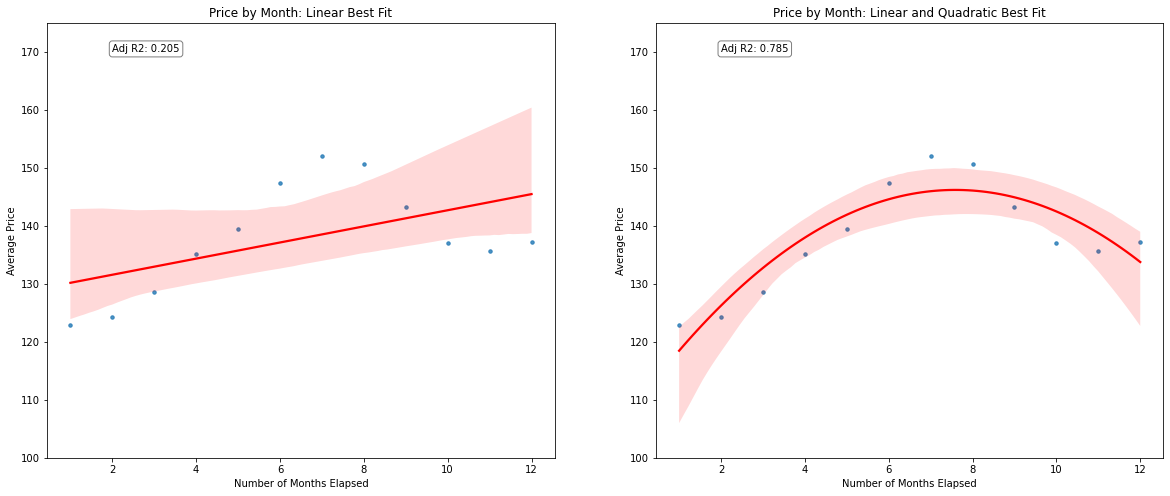

In [290]:
fig, ax = plt.subplots(1, 2, figsize = (20,8))

sns.regplot(x = month_range, y = avail_df_gb["price"], line_kws={"color": "red"}, scatter_kws={"s": 12}, ax=ax[0])
ax[0].set_title("Price by Month: Linear Best Fit")
ax[0].set_xlabel("Number of Months Elapsed")
ax[0].set_ylabel("Average Price")
ax[0].set_ylim(100, 175)

sns.regplot(x = month_range, y = avail_df_gb["price"], line_kws={"color": "red"}, scatter_kws={"s": 12}, order=2, ax=ax[1])
ax[1].set_title("Price by Month: Linear and Quadratic Best Fit")
ax[1].set_xlabel("Number of Months Elapsed")
ax[1].set_ylabel("Average Price")
ax[1].set_ylim(100, 175)

props = dict(boxstyle="round", facecolor="white", alpha=0.5)
text0 = "Adj R2: 0.205"
ax[0].text(2, 170, text0, bbox=props)
text1 = "Adj R2: 0.785"
ax[1].text(2, 170, text1, bbox=props)

# Question 3: Are individual listings changing price?

If the overall price level is changing with time, it could just be because the composition of the listing pool is changing. I'm interested in whether individual listings change price over the roughly 12 months of the dataset. 

How can I analyze this?


1. I can take fixed effects for those entering each month with `onehotencoder` and then see if a linear (and linear+quadratic) day trend still suggests rising prices.

2. Individual fixed effects and a day trend?

3. Do more AirBNB hosts enter in the busy months, at higher prices?

- I can see when houses make their first listing, and the average price of those entering each month. 

In [297]:
cal_df
indiv_df = cal_df[cal_df["available"] == True]
indiv_df

,listing_id,date,available,price,month,year
0,241032,2016-01-04,True,85.0,1,2016
1,241032,2016-01-05,True,85.0,1,2016
9,241032,2016-01-13,True,85.0,1,2016
10,241032,2016-01-14,True,85.0,1,2016
14,241032,2016-01-18,True,85.0,1,2016
...,...,...,...,...,...,...
1393207,10208623,2016-01-06,True,87.0,1,2016
1393208,10208623,2016-01-07,True,87.0,1,2016
1393211,10208623,2016-01-10,True,87.0,1,2016
1393212,10208623,2016-01-11,True,87.0,1,2016


# 1. Entries by month

In [299]:
indiv_entry_df = indiv_df.groupby("listing_id").min()
indiv_entry_df

,date,available,price,month,year
listing_id,,,,,
3335,2016-02-29,True,120.0,1,2016
4291,2016-01-04,True,82.0,1,2016
5682,2016-01-11,True,42.0,1,2016
6606,2016-01-04,True,90.0,1,2016
7369,2016-01-14,True,85.0,1,2016
...,...,...,...,...,...
10331249,2016-01-15,True,45.0,1,2016
10332096,2016-01-04,True,40.0,1,2016
10334184,2016-01-08,True,120.0,1,2016


In [307]:
entry_date = indiv_entry_df.reset_index()
entry_date = entry_date[["listing_id", "date"]]
entry_date["entry"] = entry_date["date"]
entry_date.drop("date", axis=1, inplace=True)
entry_date



#entry_date = indiv_entry_df["date"]


,listing_id,entry
0,3335,2016-02-29
1,4291,2016-01-04
2,5682,2016-01-11
3,6606,2016-01-04
4,7369,2016-01-14
...,...,...
3718,10331249,2016-01-15
3719,10332096,2016-01-04
3720,10334184,2016-01-08
3721,10339145,2016-01-04


In [ ]:
#cal_df["month"] = cal_df["date"].dt.month
#cal_df["year"] = cal_df["date"].dt.year

In [334]:
month_entry_df = indiv_df.merge(entry_date, on="listing_id")
month_entry_df["month_entered"] = month_entry_df["entry"].dt.month
month_entry_df["day"] = month_entry_df["date"].dt.day
month_entry_df

,listing_id,date,available,price,month,year,entry,month_entered,day
0,241032,2016-01-04,True,85.0,1,2016,2016-01-04,1,4
1,241032,2016-01-05,True,85.0,1,2016,2016-01-04,1,5
2,241032,2016-01-13,True,85.0,1,2016,2016-01-04,1,13
3,241032,2016-01-14,True,85.0,1,2016,2016-01-04,1,14
4,241032,2016-01-18,True,85.0,1,2016,2016-01-04,1,18
...,...,...,...,...,...,...,...,...,...
934537,10208623,2016-01-06,True,87.0,1,2016,2016-01-04,1,6
934538,10208623,2016-01-07,True,87.0,1,2016,2016-01-04,1,7
934539,10208623,2016-01-10,True,87.0,1,2016,2016-01-04,1,10
934540,10208623,2016-01-11,True,87.0,1,2016,2016-01-04,1,11


In [339]:
month_entry_df["day"] = pd.to_numeric(month_entry_df["day"])
month_entry_df["day_sq"] == month_entry_df["day"]**2


KeyError: 'day_sq'

In [337]:
month_entry_df["day_sq"] == month_entry_df["day"]**2


KeyError: 'day_sq'

In [330]:
month_entry_df["day"]**2

0          16
1          25
2         169
3         196
4         324
         ... 
934537     36
934538     49
934539    100
934540    121
934541    144
Name: day, Length: 934542, dtype: int64

In [324]:
month_entry_model_df = month_entry_df[["price", "month_entered", "day"]]

,listing_id,date,available,price,month,year,entry
934268,10267360,2016-01-05,True,93.0,1,2016,2016-01-05
934269,10267360,2016-01-06,True,93.0,1,2016,2016-01-05
934270,10267360,2016-01-07,True,93.0,1,2016,2016-01-05
934271,10267360,2016-01-08,True,75.0,1,2016,2016-01-05
934272,10267360,2016-01-09,True,75.0,1,2016,2016-01-05
...,...,...,...,...,...,...,...
934351,10267360,2016-03-28,True,93.0,3,2016,2016-01-05
934352,10267360,2016-03-29,True,93.0,3,2016,2016-01-05
934353,10267360,2016-03-30,True,93.0,3,2016,2016-01-05
934354,10267360,2016-03-31,True,93.0,3,2016,2016-01-05


In [321]:
month_entry_df["listing_id"].unique()

array([  241032,   953595,  3308979, ..., 10267360,  9604740, 10208623],
      dtype=int64)